In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from scipy.integrate import quad
%matplotlib inline

In [2]:
# log of factorial, vectorized
log_fact = np.vectorize(lambda x: np.sum(np.log(range(1,x+1))))

class BinarizedDistribution:
    
    def __init__(self, distribution, nbins, nevents=10000):
        self.distribution = distribution
        self.nbins = nbins
        self.nevents = nevents
        
        x = distribution.rvs(10000)
        self.xmin, self.xmax = np.min(x), np.max(x)
        
        self.bins = np.linspace(self.xmin, self.xmax, nbins+1)
        self.bins[0], self.bins[-1] = -np.inf, np.inf

        # compute expected number of data points in each bin
        self.ei = []
        for i in range(len(self.bins)-1):    
            self.ei.append(nevents * quad(self.distribution.pdf, self.bins[i], self.bins[i+1])[0])
        self.ei = np.round(self.ei).astype(int)
        self.ei[-1] = (nevents - np.sum(self.ei[:-1]))
        
        # poisson model for each bin
        self.poissons = [stats.poisson(mu=i) for i in self.ei]
        
    def pdf(self, x):
        return self.distribution.pdf(x)
    
    def loglkhood(self, x):
        return np.sum(np.log(self.pdf(x)))
        
    def loglkhood_bins(self, b):
        assert len(b)==self.nbins, f"binarized data must have {self.nbins} bins"
        b[b==0]=1 # bins to have at least 1 event to avoid numerical problems with log
        return np.sum([np.log(self.poissons[i].pmf(b[i])) for i in range(len(b))])
        # manual computation of the poisson
        return np.sum(b*np.log(self.ei)-log_fact(b)-(self.ei))        

    def sample_loglkhood(self, n):
        r = []
        for _ in range(n):
            x = self.rvs()
            r.append([self.loglkhood(x), self.loglkhood_bins(self.binarize(x))])
        return pd.DataFrame(r, columns=["loglkhood", "loglkhood_bins"])
    
    def binarize(self, x):
        """
        binarizes one experiments, x must contain events, such as returned by rvs
        """
        return np.histogram(x, self.bins)[0]
        
    def rvs(self):
        return self.distribution.rvs(self.nevents)
    
    def plot_binarized(self, h, plot_bins_borders=False, **kwargs):
        """
        h: vector with counts of events on each bin, such as returned by binarize
        """
        bins = self.bins.copy()
        bsize = bins[2] - bins[1]
        bins[0]  = bins[1] - bsize
        bins[-1] = bins[-2] + bsize
        plt.bar(bins[:-1]+bsize/2, h, bsize*.8, label="binarized sample", **kwargs)        
        plt.ylabel("number of events")
        plt.grid();
        if plot_bins_borders:
            for i in self.bins[1:-1]:
                plt.axvline(i, color="red", alpha=1, ls="--")
        plt.plot(bins[:-1]+bsize/2, self.ei, label="expected", color="black")
        plt.legend();
        
    def plot_pdf(self, **kwargs):
        xr = np.linspace(self.xmin, self.xmax, 100)
        plt.plot(xr, self.distribution.pdf(xr), **kwargs)
        plt.ylabel("probability")
        plt.grid();
        

## binarize any distribution from `scipy.stats`

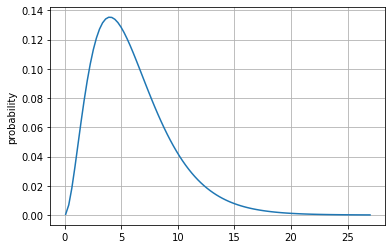

In [3]:
bd = BinarizedDistribution(stats.beta(a=5, b=1), nbins=20)
bd = BinarizedDistribution(stats.chi2(df=6), nbins=20)
bd.plot_pdf()

## get a sample from the distribution

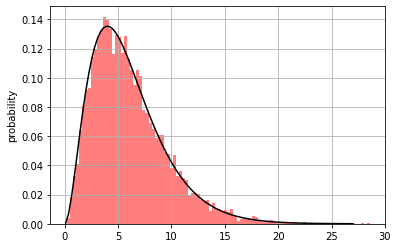

In [4]:
x = bd.rvs()
plt.hist(x, bins=100, density=True, color="red", alpha=.5, label="sample")
bd.plot_pdf(label="pdf", color="black")

## binarize the sample

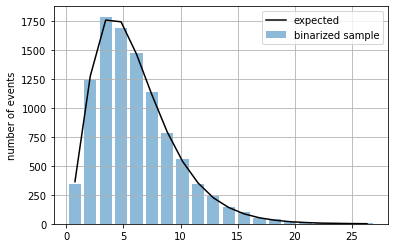

In [5]:
xb = bd.binarize(x)
bd.plot_binarized(xb, alpha=.5)


## likelihoods are very different

In [6]:
bd.loglkhood(x), bd.loglkhood_bins(xb)

(-25514.345265449603, -77.44924628393696)

## and not related!!!!

In [7]:
k = bd.sample_loglkhood(500)

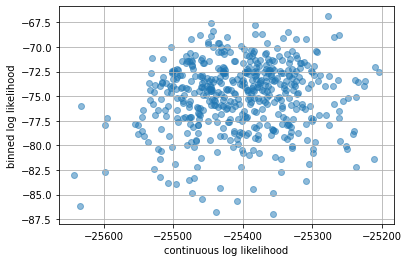

In [8]:
plt.scatter(k.loglkhood, k.loglkhood_bins, alpha=.5)
plt.xlabel("continuous log likelihood")
plt.ylabel("binned log likelihood")
plt.grid();